The competition dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this playground competition. Based on individual trip attributes, participants should predict the duration of each trip in the test set.

# Import data

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [39]:
df = pd.read_csv('datasets/train.csv', parse_dates=['pickup_datetime', 'dropoff_datetime'])

In [40]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


Data fields
- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
- trip_duration - duration of the trip in seconds


Disclaimer: The decision was made to not remove dropoff coordinates from the dataset order to provide an expanded set of variables to use in Kernels.

# Create features

In [42]:
def distance(lat1, lat2, lon1, lon2):
    '''
    Simple distance calculator, assume angle is so small since we are only in new york city
    Returns distance in km
    '''
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = np.math.radians(lon1)
    lon2 = np.math.radians(lon2)
    lat1 = np.math.radians(lat1)
    lat2 = np.math.radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.math.sin(dlat / 2)**2 + np.math.cos(lat1) * np.math.cos(lat2) * np.math.sin(dlon / 2)**2
 
    c = 2 * np.math.asin(np.sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)
    

In [43]:
df['trip_distance_km'] = df.apply(lambda x: distance(x['pickup_latitude'], x['dropoff_latitude'], x['pickup_longitude'], x['dropoff_longitude']),axis=1)
	

# EDA

## Overview

In [44]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,trip_distance_km
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02,3.440864e+00
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03,4.296538e+00
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02,1.231837e+00
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02,2.093717e+00
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03,3.875337e+00
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06,1.240909e+03


In [45]:
feat_num = ['passenger_count', 'trip_distance_km']
feat_cat = ['vendor_id', 'store_and_fwd_flag']
feat_dt = ['pickup_datetime', 'dropoff_datetime']

## Numerical features
- passenger count (remove from model, assume doesn't affect duration)
- distribution of trip distance
    - exponentially distributed
    - zeros and outliers to be removed


In [46]:
df[feat_num].describe()

,passenger_count,trip_distance_km
count,1.458644e+06,1.458644e+06
mean,1.664530e+00,3.440864e+00
std,1.314242e+00,4.296538e+00
min,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.231837e+00
50%,1.000000e+00,2.093717e+00
75%,2.000000e+00,3.875337e+00
max,9.000000e+00,1.240909e+03


<AxesSubplot:xlabel='trip_distance_km'>

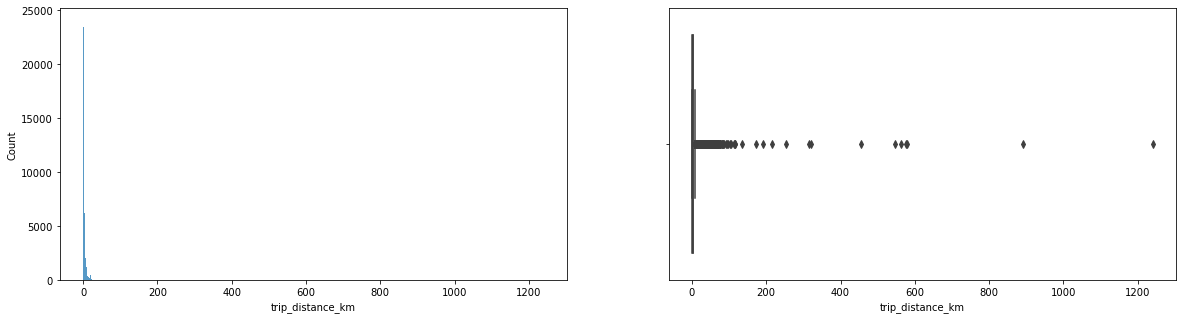

In [47]:
plt.figure(figsize=(20,5))

plt.subplot(121)
sns.histplot(data=df, x='trip_distance_km')
plt.subplot(122)
sns.boxplot(data=df, x='trip_distance_km')

In [48]:
def remove_distance_zeros_and_outliers(df):
    '''
    remove records from df having trip_distance_km as zeros or outliers
    '''
    df = df[df['trip_distance_km'] != 0]
    trip_distance_mean, trip_distance_std = df['trip_distance_km'].mean(), df['trip_distance_km'].std()
    trip_distance_lower = trip_distance_mean - 3*trip_distance_std
    trip_distance_upper = trip_distance_mean + 3*trip_distance_std
    return df[(df['trip_distance_km'] < trip_distance_upper) & (df['trip_distance_km'] > trip_distance_lower)]
df = remove_distance_zeros_and_outliers(df)
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,trip_distance_km
count,1.412726e+06,1.412726e+06,1.412726e+06,1.412726e+06,1.412726e+06,1.412726e+06,1.412726e+06,1.412726e+06
mean,1.533856e+00,1.662436e+00,-7.397658e+01,4.075262e+01,-7.397492e+01,4.075274e+01,9.012121e+02,2.967983e+00
std,4.988526e-01,1.313582e+00,6.450994e-02,2.567165e-02,6.431499e-02,3.053249e-02,4.037401e+03,2.698695e+00
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.531031e+01,-1.219333e+02,3.517355e+01,1.000000e+00,4.241750e-04
25%,1.000000e+00,1.000000e+00,-7.399206e+01,4.073840e+01,-7.399137e+01,4.073689e+01,3.910000e+02,1.220943e+00
50%,2.000000e+00,1.000000e+00,-7.398200e+01,4.075471e+01,-7.397993e+01,4.075488e+01,6.470000e+02,2.042507e+00
75%,2.000000e+00,2.000000e+00,-7.396827e+01,4.076865e+01,-7.396369e+01,4.077001e+01,1.030000e+03,3.645223e+00
max,2.000000e+00,8.000000e+00,-7.207433e+01,4.169680e+01,-7.202241e+01,4.169335e+01,2.227612e+06,1.635362e+01


<AxesSubplot:xlabel='trip_distance_km'>

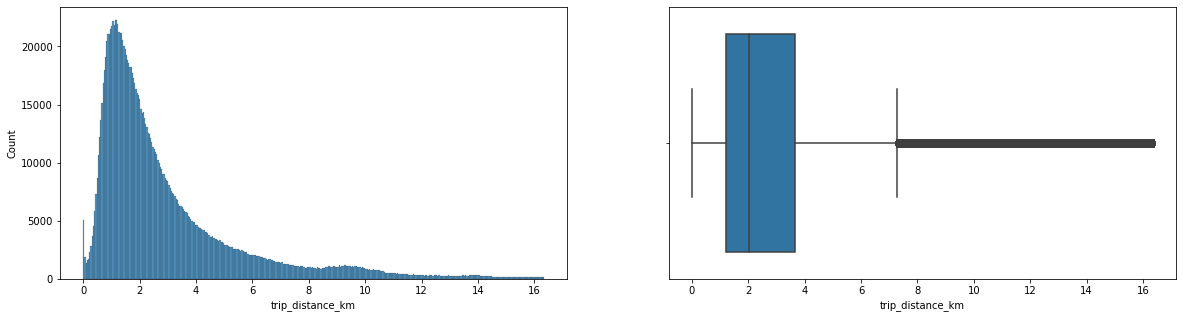

In [49]:
plt.figure(figsize=(20,5))

plt.subplot(121)
sns.histplot(data=df, x='trip_distance_km')
plt.subplot(122)
sns.boxplot(data=df, x='trip_distance_km')

## Categorical features
- 2 vendors almost equal in number of trips
- store_and_fwd_flag overwhelmlingly = N (can be removed from model)

<AxesSubplot:xlabel='store_and_fwd_flag', ylabel='count'>

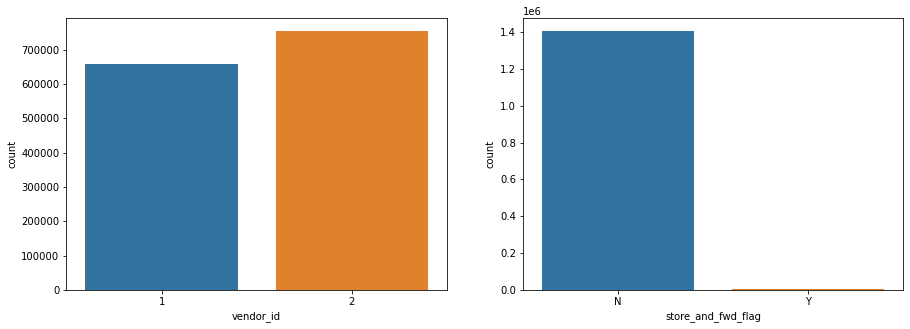

In [56]:
plt.figure(figsize=(15,5))

plt.subplot(121)
sns.countplot(data=df, x='vendor_id')
plt.subplot(122)
sns.countplot(data=df, x='store_and_fwd_flag')

## Datetime features
- combine with other features to look for info

In [57]:
print(df['pickup_datetime'].min(), '-', df['pickup_datetime'].max())
print(df['dropoff_datetime'].min(), '-', df['dropoff_datetime'].max())

2016-01-01 00:00:17 - 2016-06-30 23:59:39
2016-01-01 00:03:31 - 2016-07-01 23:02:03


Text(0, 0.5, 'Trip counts')

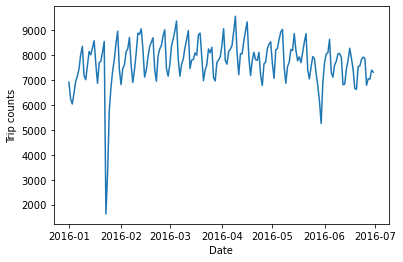

In [73]:
df.groupby(df['pickup_datetime'].dt.date)['id'].count().plot()
plt.xlabel('Date')
plt.ylabel('Trip counts')

Text(0, 0.5, 'Trip counts')

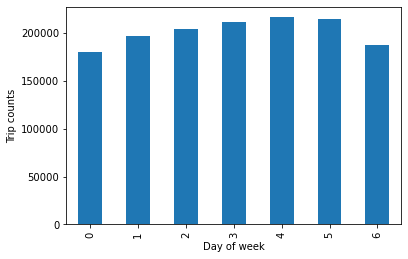

In [75]:
df.groupby(df['pickup_datetime'].dt.day_of_week)['id'].count().plot(kind='bar')
plt.xlabel('Day of week')
plt.ylabel('Trip counts')

Text(0, 0.5, 'Trip counts')

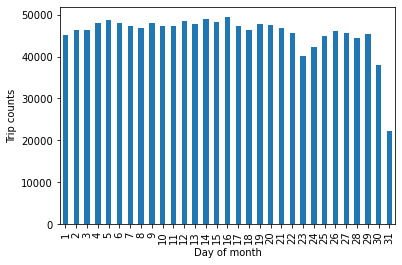

In [76]:
df.groupby(df['pickup_datetime'].dt.day)['id'].count().plot(kind='bar')
plt.xlabel('Day of month')
plt.ylabel('Trip counts')

Text(0, 0.5, 'Trip counts')

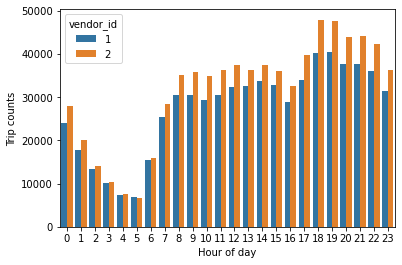

In [77]:
sns.countplot(data=df, x=df['pickup_datetime'].dt.hour, hue='vendor_id')
plt.xlabel('Hour of day')
plt.ylabel('Trip counts')

## Target variable

# Preprocess data for model

# Train model and make predictions